In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from category_encoders import OneHotEncoder, OrdinalEncoder
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from pdpbox.pdp import pdp_isolate, pdp_plot, pdp_interact, pdp_interact_plot
from shap import TreeExplainer, initjs, force_plot
from sklearn.linear_model import LinearRegression, Ridge
from numpy.random import permutation
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
import plotly.graph_objects as go
import chart_studio

In [6]:
DATA_PATH = './data/'

In [45]:
###DATA WRANGLING/EDA

def wrangle(data):
    df = pd.read_csv(data,
                parse_dates=['last_scraped','host_since']
               ).set_index('last_scraped')
    
    #Dropping columns with high similarity columns
    df.drop(columns=['id','host_id','host_url','host_location',
                    'host_about','host_response_rate','host_listings_count',
                    'host_neighbourhood','host_total_listings_count',
                    'calendar_last_scraped','calculated_host_listings_count',
                    'calculated_host_listings_count_entire_homes',
                    'calculated_host_listings_count_private_rooms',
                    'calculated_host_listings_count_shared_rooms',
                    'host_has_profile_pic','bathrooms','has_availability'], inplace=True)
    
    #Dropping columns about reviews and columns with low gini importance
    df.drop(columns=['review_scores_accuracy','review_scores_cleanliness',
                    'review_scores_checkin', 'review_scores_communication','review_scores_location',
                    'review_scores_value','reviews_per_month','minimum_nights','maximum_nights',
                    'availability_30','availability_60','availability_90',
                    'availability_365','number_of_reviews_ltm','number_of_reviews_l30d','minimum_minimum_nights', 'maximum_minimum_nights',
                    'minimum_maximum_nights', 'maximum_maximum_nights',
                    'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'longitude', 'latitude','neighbourhood'], inplace=True)
    
    #Converted target as object into float
    df['price']  = df['price'].str.strip('$')
    df['price']  = df['price'].str.replace(',','').astype(float)
    
    #Dropped outliers
    df = df.loc[df['price'] < 50000]
    
    #Setting review scores rating as a categorical feature
    df['review_scores_rating'] = df['review_scores_rating'].fillna(0).round(-1).astype('int').astype('str')
    df['review_scores_rating'] = np.where(df['number_of_reviews']==0, 'no past ratings', df['review_scores_rating'])
    
    #Making use of the 'amenities' column
    items = ['Wireless Internet','Air conditioning', 'Kitchen', 'Heating','Family/kid friendly', 'Essentials', 'Hair dryer', 'Iron', 
                 'Smoke detector', 'Shampoo', 'Hangers', 'Hair dryer', 'Fire extinguisher', 'Laptop friendly workspace', 'First aid kit', 'Indoor fireplace',
                 'TV','Cable TV', 'Elevator in building']
    
    #Dropped High Cardinality and single value columns
    for item in items:
         df[item]=np.where(df['amenities'].str.contains(item), 1, 0)
    numcard = 50

    highcard = [col for col in df.select_dtypes(exclude='number')
            if df[col].nunique() > numcard]
    lowcard = [col for col in df
            if df[col].nunique() <= 1]           
    df.drop(columns=highcard, inplace=True)
    df.drop(columns=lowcard, inplace=True)
    
    
    #Converted t and f object type into 1 and 0
    df.replace('t',1, inplace=True)
    df.replace('f',0, inplace=True)
    
    #Preprocessed NaN values
    df['host_response_time'].fillna('within an hour',inplace=True)
    df['bedrooms'].fillna(1,inplace=True)
    
    #Dropping rows with NA values
    df = df.dropna(axis=0, subset=['bedrooms', 'beds'])
  
    
    return df

In [46]:
df = wrangle(DATA_PATH+'listings.csv')



In [47]:
dfc = wrangle(DATA_PATH+'chicago.csv')

In [48]:
dfc_ = pd.read_csv(DATA_PATH+'chicago.csv')

In [49]:
dfc_.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6386 entries, 0 to 6385
Data columns (total 74 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            6386 non-null   int64  
 1   listing_url                                   6386 non-null   object 
 2   scrape_id                                     6386 non-null   int64  
 3   last_scraped                                  6386 non-null   object 
 4   name                                          6386 non-null   object 
 5   description                                   6366 non-null   object 
 6   neighborhood_overview                         4652 non-null   object 
 7   picture_url                                   6386 non-null   object 
 8   host_id                                       6386 non-null   int64  
 9   host_url                                      6386 non-null   o

In [50]:
dfc.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6275 entries, 2021-04-22 to 2021-04-21
Data columns (total 26 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   host_response_time      6275 non-null   object 
 1   host_is_superhost       6107 non-null   float64
 2   host_identity_verified  6107 non-null   float64
 3   property_type           6275 non-null   object 
 4   room_type               6275 non-null   object 
 5   accommodates            6275 non-null   int64  
 6   bathrooms_text          6273 non-null   object 
 7   bedrooms                6275 non-null   float64
 8   beds                    6275 non-null   float64
 9   price                   6275 non-null   float64
 10  number_of_reviews       6275 non-null   int64  
 11  review_scores_rating    6275 non-null   object 
 12  instant_bookable        6275 non-null   int64  
 13  Air conditioning        6275 non-null   int32  
 14  Kitchen               

In [54]:
dfc['property_type'].value_counts()

Entire apartment                      2843
Private room in apartment              694
Entire condominium                     653
Private room in house                  434
Entire house                           380
Private room in condominium            230
Entire guest suite                     164
Room in boutique hotel                 127
Entire serviced apartment              120
Entire loft                            117
Entire townhouse                        92
Private room in townhouse               62
Private room in bungalow                42
Entire guesthouse                       41
Shared room in apartment                41
Room in hotel                           32
Private room in loft                    31
Shared room in house                    22
Private room in bed and breakfast       20
Private room in guest suite             19
Entire bungalow                         17
Shared room in condominium              16
Room in serviced apartment              13
Room in bed

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10889 entries, 2021-01-04 to 2021-01-01
Data columns (total 27 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   host_response_time      10889 non-null  object 
 1   host_is_superhost       10873 non-null  float64
 2   host_identity_verified  10873 non-null  float64
 3   neighbourhood_cleansed  10889 non-null  object 
 4   latitude                10889 non-null  float64
 5   room_type               10889 non-null  object 
 6   accommodates            10889 non-null  int64  
 7   bathrooms_text          10876 non-null  object 
 8   bedrooms                10889 non-null  float64
 9   beds                    10889 non-null  float64
 10  price                   10889 non-null  float64
 11  number_of_reviews       10889 non-null  int64  
 12  review_scores_rating    10889 non-null  object 
 13  instant_bookable        10889 non-null  int64  
 14  Air conditioning     

In [29]:
###SPLITTING DATA
target = 'price'
y = df[target]
X = df.drop(columns=target)

In [30]:
cutoff = '2021-01-04'
mask = X.index < cutoff
X_train, y_train = X.loc[mask], y.loc[mask]
X_test, y_test = X.loc[~mask], y.loc[~mask]

In [31]:
###ESTABLISHING BASELINE
print('Mean AirBnB Price:', y_train.mean())
y_pred = [y_train.mean()] * len(y_train)
print('Baseline MAE:', mean_absolute_error(y_train, y_pred))
print('Baseline RMSE:', mean_squared_error(y_train, y_pred, squared=False))

Mean AirBnB Price: 10374.170921579851
Baseline MAE: 6159.698199343448
Baseline RMSE: 8320.812532933393


In [32]:
###BUILDING MODELS

#Ridge Regressor

model_rr = make_pipeline(
    OneHotEncoder(),
    SimpleImputer(),
    Ridge(alpha=10)
)

model_rr.fit(X_train, y_train);    

In [33]:
#RandomForestRegressor model

model_rf = make_pipeline(
    OneHotEncoder(),
    SimpleImputer(),
    RandomForestRegressor(random_state=42)
)

model_rf.fit(X_train, y_train); 

In [34]:

#XGboostRegressor model

model_xgb = make_pipeline(
    OneHotEncoder(),
    SimpleImputer(),
    XGBRegressor(random_state=42, 
                 n_jobs=-1,
                 verbose=True)
);


model_xgb.fit(X_train, y_train);



[07:54:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




In [35]:
###CHECKING METRICS

#Ridge model metrics
y_pred_train_rr = model_rr.predict(X_train)
y_pred_test_rr = model_rr.predict(X_test)
train_MAE_rr = mean_absolute_error(y_train, y_pred_train_rr)
test_MAE_rr = mean_absolute_error(y_test, y_pred_test_rr)
train_RMSE_rr = mean_squared_error(y_train, y_pred_train_rr, squared=False)
test_RMSE_rr = mean_squared_error(y_test, y_pred_test_rr, squared=False)

print('RIDGE REGRESSOR METRICS:')
print('Train MAE:',train_MAE_rr)
print('Test MAE:', test_MAE_rr)
print('Train RMSE:', train_RMSE_rr)
print('Test RMSE:', test_RMSE_rr)
print('Training R^2:', r2_score(y_train, model_rr.predict(X_train)))
print('Test R^2:', r2_score(y_test, model_rr.predict(X_test)))
print('Training Accuracy:', model_rr.score(X_train, y_train))
print('Test Accuracy:', model_rr.score(X_test, y_test))

#RF Regressor metrics
y_pred_train_rf = model_rf.predict(X_train)
y_pred_test_rf = model_rf.predict(X_test)
train_MAE_rf = mean_absolute_error(y_train, y_pred_train_rf)
test_MAE_rf = mean_absolute_error(y_test, y_pred_test_rf)
train_RMSE_rf = mean_squared_error(y_train, y_pred_train_rf, squared=False)
test_RMSE_rf = mean_squared_error(y_test, y_pred_test_rf, squared=False)
print('')
print('RF REGRESSOR METRICS:')
print('Train MAE:',train_MAE_rf)
print('Test MAE:', test_MAE_rf)
print('Train RMSE:', train_RMSE_rf)
print('Test RMSE:', test_RMSE_rf)
print('Training R^2:', r2_score(y_train, model_rf.predict(X_train)))
print('Test R^2:', r2_score(y_test, model_rf.predict(X_test)))
print('Training Accuracy:', model_rf.score(X_train, y_train))
print('Test Accuracy:', model_rf.score(X_test, y_test))

#XGB model metrics
y_pred_train_xgb = model_xgb.predict(X_train)
y_pred_test_xgb = model_xgb.predict(X_test)
train_MAE_xgb = mean_absolute_error(y_train, y_pred_train_xgb)
test_MAE_xgb = mean_absolute_error(y_test, y_pred_test_xgb)
train_RMSE_xgb = mean_squared_error(y_train, y_pred_train_xgb, squared=False)
test_RMSE_xgb = mean_squared_error(y_test, y_pred_test_xgb, squared=False)
print('')
print('XGBOOST METRICS:')
print('Train MAE:',train_MAE_xgb)
print('Test MAE:', test_MAE_xgb)
print('Train RMSE:', train_RMSE_xgb)
print('Test RMSE:', test_RMSE_xgb)
print('Training R^2:', r2_score(y_train, model_xgb.predict(X_train)))
print('Test R^2:', r2_score(y_test, model_xgb.predict(X_test)))
print('Training Accuracy:', model_xgb.score(X_train, y_train))
print('Test Accuracy:', model_xgb.score(X_test, y_test))


RIDGE REGRESSOR METRICS:
Train MAE: 4602.435696509511
Test MAE: 4501.80550619083
Train RMSE: 6557.48605040941
Test RMSE: 6241.4487584777835
Training R^2: 0.3789261043845561
Test R^2: 0.32879880382825555
Training Accuracy: 0.3789261043845561
Test Accuracy: 0.32879880382825555

RF REGRESSOR METRICS:
Train MAE: 1363.2761713322611
Test MAE: 3845.0794363642394
Train RMSE: 2187.7845181987095
Test RMSE: 5798.00382980578
Training R^2: 0.9308682398595485
Test R^2: 0.42078620227055996
Training Accuracy: 0.9308682398595485
Test Accuracy: 0.42078620227055996

XGBOOST METRICS:
Train MAE: 2641.825481262382
Test MAE: 4074.073767227272
Train RMSE: 3899.7179910243995
Test RMSE: 6007.468312194451
Training R^2: 0.7803481177959176
Test R^2: 0.37817972218242446
Training Accuracy: 0.7803481177959176
Test Accuracy: 0.37817972218242446


In [36]:
###TUNING (HYPERPARAM TUNING AND COMPARING GINI IMPORTANCE AND PERMUTATION IMPORTANCE)

#Hyperparam tuning for ridge model
rr_params = {
    'simpleimputer__strategy': ['mean', 'median'],
    'ridge__alpha': [1,5,10,15,20,25],
}

model_rr_gs = GridSearchCV(
    model_rr,
    param_grid=rr_params,
    cv=5,
    n_jobs=-1,
    verbose=1
)

model_rr_gs.fit(X_train, y_train);

Fitting 5 folds for each of 12 candidates, totalling 60 fits


In [37]:


rf_params = {
    'simpleimputer__strategy': ['mean', 'median'],
    'randomforestregressor__n_estimators': [100,150,200,250,300],
    'randomforestregressor__max_depth': range(5, 36, 3)
}

model_rf_gs = GridSearchCV(
    model_rf,
    param_grid=rf_params,
    cv=5,
    n_jobs=-1,
    verbose=1
)

model_rf_gs.fit(X_train, y_train);


Fitting 5 folds for each of 110 candidates, totalling 550 fits


In [38]:
xgb_params = {
    'simpleimputer__strategy': ['mean', 'median'],
    'xgbregressor__max_depth': range(3,15,3),
    'xgbregressor__gamma': range(1,5,1),
    'xgbregressor__n_estimators': range(5,30,5)
}

model_xgb_gs = GridSearchCV(
    model_xgb,
    param_grid=xgb_params,
    cv=5,
    n_jobs=-1,
    verbose=1
)

model_xgb_gs.fit(X_train, y_train);


Fitting 5 folds for each of 160 candidates, totalling 800 fits
[08:20:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




In [39]:
#Ridge modelv2 metrics
y_pred_train_rr_gs = model_rr_gs.predict(X_train)
y_pred_test_rr_gs = model_rr_gs.predict(X_test)
train_MAE_rr_gs = mean_absolute_error(y_train, y_pred_train_rr_gs)
test_MAE_rr_gs = mean_absolute_error(y_test, y_pred_test_rr_gs)
train_RMSE_rr_gs = mean_squared_error(y_train, y_pred_train_rr_gs, squared=False)
test_RMSE_rr_gs = mean_squared_error(y_test, y_pred_test_rr_gs, squared=False)
print('RIDGE REGRESSORv2 METRICS:')
print('Train MAE:',train_MAE_rr_gs)
print('Test MAE:', test_MAE_rr_gs)
print('Train RMSE:', train_RMSE_rr_gs)
print('Test RMSE:', test_RMSE_rr_gs)
print('Training R^2:', r2_score(y_train, model_rr_gs.predict(X_train)))
print('Test R^2:', r2_score(y_test, model_rr_gs.predict(X_test)))
#RF modelv2 metrics
y_pred_train_rf_gs = model_rf_gs.predict(X_train)
y_pred_test_rf_gs = model_rf_gs.predict(X_test)
train_MAE_rf_gs = mean_absolute_error(y_train, y_pred_train_rf_gs)
test_MAE_rf_gs = mean_absolute_error(y_test, y_pred_test_rf_gs)
train_RMSE_rf_gs = mean_squared_error(y_train, y_pred_train_rf_gs, squared=False)
test_RMSE_rf_gs = mean_squared_error(y_test, y_pred_test_rf_gs, squared=False)
print('')
print('RF REGRESSORv2 METRICS:')
print('Train MAE:',train_MAE_rf_gs)
print('Test MAE:', test_MAE_rf_gs)
print('Train RMSE:', train_RMSE_rf_gs)
print('Test RMSE:', test_RMSE_rf_gs)
print('Training R^2:', r2_score(y_train, model_rf_gs.predict(X_train)))
print('Test R^2:', r2_score(y_test, model_rf_gs.predict(X_test)))

#XGB modelv2 metrics
y_pred_train_xgb_gs = model_xgb_gs.predict(X_train)
y_pred_test_xgb_gs = model_xgb_gs.predict(X_test)
train_MAE_xgb_gs = mean_absolute_error(y_train, y_pred_train_xgb_gs)
test_MAE_xgb_gs = mean_absolute_error(y_test, y_pred_test_xgb_gs)
train_RMSE_xgb_gs = mean_squared_error(y_train, y_pred_train_xgb_gs, squared=False)
test_RMSE_xgb_gs = mean_squared_error(y_test, y_pred_test_xgb_gs, squared=False)
print('')
print('XGBoost Regressorv2 METRICS:')
print('Train MAE:',train_MAE_xgb_gs)
print('Test MAE:', test_MAE_xgb_gs)
print('Train RMSE:', train_RMSE_xgb_gs)
print('Test RMSE:', test_RMSE_xgb_gs)
print('Training R^2:', r2_score(y_train, model_xgb_gs.predict(X_train)))
print('Test R^2:', r2_score(y_test, model_xgb_gs.predict(X_test)))
print('Model best score:', model_xgb_gs.best_score_)

RIDGE REGRESSORv2 METRICS:
Train MAE: 4609.767261210997
Test MAE: 4504.085298604366
Train RMSE: 6574.13254781096
Test RMSE: 6247.755495366201
Training R^2: 0.3757688494356979
Test R^2: 0.3274416740361392

RF REGRESSORv2 METRICS:
Train MAE: 3999.4999526342135
Test MAE: 4361.248015195212
Train RMSE: 5695.3699634340555
Test RMSE: 6116.085985011245
Training R^2: 0.5314969678408051
Test R^2: 0.35549087873353336

XGBoost Regressorv2 METRICS:
Train MAE: 4380.359000543901
Test MAE: 4435.96404292568
Train RMSE: 6295.663084702099
Test RMSE: 6197.928507633819
Training R^2: 0.4275316485371722
Test R^2: 0.3381264471849652
Model best score: 0.34796845213725724


In [40]:
#Gini importance
importances = model_xgb.named_steps['xgbregressor'].feature_importances_

feat_imp = pd.Series(importances, index=X.columns).sort_values()
feat_imp.tail(10).plot(kind='barh')
plt.xlabel('Gini importance')
plt.ylabel('Feature')
plt.title('Feature importance for model_xgb');

ValueError: Length of passed values is 125, index implies 26.

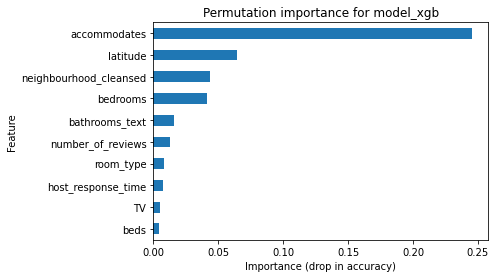

In [41]:
#Permutation importance
perm_imp = permutation_importance(model_xgb_gs,
                                   X_test,
                                   y_test,
                                   n_jobs=-1,
                                   random_state=42)

data_ = {'importances_mean' : perm_imp['importances_mean'],
        'importances_std' : perm_imp['importances_std']}


permdf = pd.DataFrame(data_, index=X_test.columns)
permdf.sort_values(by='importances_mean', inplace=True)

permdf['importances_mean'].tail(10).plot(kind='barh')
plt.xlabel('Importance (drop in accuracy)')
plt.ylabel('Feature')
plt.title('Permutation importance for model_xgb');

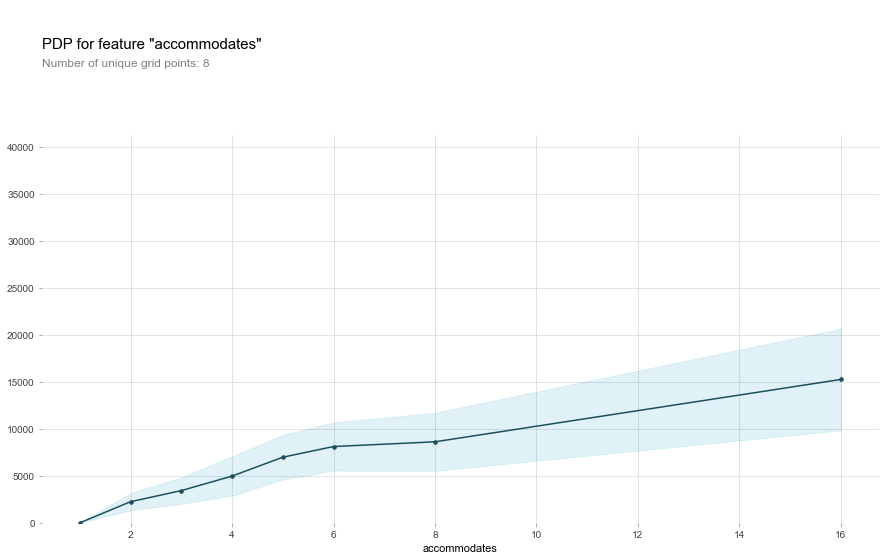

In [42]:
###COMMUNICATING RESULTS

feature = 'accommodates'

#Plotting partial dependency for 'accommodates' feature
isolate = pdp_isolate(
    model=model_xgb,
    dataset=X_test,
    model_features=X_test.columns,
    feature=feature
)

pdp_plot(isolate, feature_name=feature);

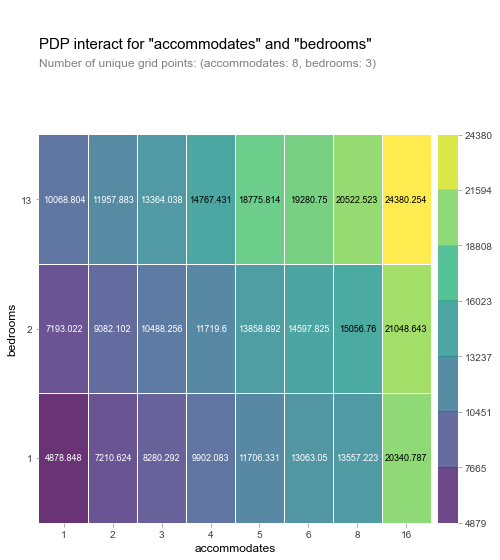

In [43]:
#Plotting partial dependency for the first top 2 features:
#('bedroom' and 'accomodates')

top2feat = ['accommodates', 'bedrooms']

interact = pdp_interact(
    model=model_xgb,
    dataset=X_test,
    model_features=X_test.columns,
    features=top2feat
)

pdp_interact_plot(interact, plot_type='grid',feature_names=top2feat);

In [ ]:
location = ['longitude', 'latitude']


interact = pdp_interact(
    model=model_xgb,
    dataset=X_test,
    model_features=X_test.columns,
    features = location
)

pdp_interact_plot(interact, plot_type='grid',feature_names=location);

In [ ]:
df.corr()

In [55]:
!pip install joblib

In [57]:
from joblib import dump

dump(model_rf_gs, "pipeline.joblib", compress=True)

['pipeline.joblib']